<a href="https://colab.research.google.com/github/pedrosena138/recommendation-system/blob/main/Movie_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movie Recommendation System with Matrix Factorization

For manipulate this Colab do this following steps:
1. File -> Save Drive copy
2. Edit -> Notebook configurations
3. Hardware accelerator, select GPU

# Import libs

In [1]:
%matplotlib inline

!pip install lenskit

import requests
import io
import pandas as pd
import numpy as np
from zipfile import ZipFile
from sklearn.cluster import KMeans
import lenskit.datasets as ds

# PyTorch
import torch
from torch.autograd import Variable
from tqdm.notebook import tqdm
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader # package that helps transform your data to machine learning readiness

import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 74 kB 2.5 MB/s 
     |████████████████████████████████| 256 kB 9.9 MB/s 
     |████████████████████████████████| 87 kB 9.0 MB/s 


# 1. Analysing the dataset

In [2]:
r = requests.get('https://files.grouplens.org/datasets/movielens/ml-latest-small.zip')
zip_file = ZipFile(io.BytesIO(r.content))
zip_file.extractall("data")

In [3]:
data = ds.MovieLens('data/ml-latest-small')

print(f'Movies dataframe shape is: {data.movies.shape}')
print(f'Ratings dataframe shape is: {data.ratings.shape}')

Movies dataframe shape is: (9742, 2)
Ratings dataframe shape is: (100836, 4)


In [4]:
data.movies.head()

,title,genres
item,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [5]:
data.ratings.head()

,user,item,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
average_ratings = (data.ratings).groupby('item').agg(count=('user', 'size'), rating=('rating', 'mean')).reset_index()

sorted_avg_ratings = average_ratings.sort_values(by="rating", ascending=False)
joined_data = sorted_avg_ratings.join(data.movies[['title', 'genres']], on='item')
joined_data = joined_data[joined_data.columns[1:]]

joined_data.head(10)

,count,rating,title,genres
7638,1,5.0,Paper Birds (Pájaros de papel) (2010),Comedy|Drama
8089,1,5.0,"Act of Killing, The (2012)",Documentary
9065,1,5.0,Jump In! (2007),Comedy|Drama|Romance
9076,1,5.0,Human (2015),Documentary
9078,1,5.0,L.A. Slasher (2015),Comedy|Crime|Fantasy
4245,1,5.0,Lady Jane (1986),Drama|Romance
8136,1,5.0,Bill Hicks: Revelations (1993),Comedy
8130,1,5.0,Justice League: Doom (2012),Action|Animation|Fantasy
4240,1,5.0,Open Hearts (Elsker dig for evigt) (2002),Romance
9104,1,5.0,Formula of Love (1984),Comedy


In [7]:
minimum_rating_count = 200

average_ratings = (data.ratings).groupby(['item']).mean()
rating_counts = (data.ratings).groupby(['item']).count()

average_ratings = average_ratings.loc[rating_counts['rating'] > minimum_rating_count ]
sorted_avg_ratings = average_ratings.sort_values(by="rating", ascending=False)

joined_data = sorted_avg_ratings.join(data.movies['genres'], on='item')
joined_data = joined_data.join(data.movies['title'], on='item')

recommended_data = joined_data[joined_data.columns[1:]].drop('timestamp', axis=1)
recommended_data['rating'] = recommended_data['rating'].apply(lambda x: round(x, 2))

print(f'TOP 10 RECOMMENDATIONS WITH AT LEAST {minimum_rating_count} RATINGS:')
recommended_data.head(10)

TOP 10 RECOMMENDATIONS WITH AT LEAST 200 RATINGS:


,rating,genres,title
item,,,
318,4.43,Crime|Drama,"Shawshank Redemption, The (1994)"
2959,4.27,Action|Crime|Drama|Thriller,Fight Club (1999)
50,4.24,Crime|Mystery|Thriller,"Usual Suspects, The (1995)"
260,4.23,Action|Adventure|Sci-Fi,Star Wars: Episode IV - A New Hope (1977)
527,4.22,Drama|War,Schindler's List (1993)
1196,4.22,Action|Adventure|Sci-Fi,Star Wars: Episode V - The Empire Strikes Back...
296,4.20,Comedy|Crime|Drama|Thriller,Pulp Fiction (1994)
2571,4.19,Action|Sci-Fi|Thriller,"Matrix, The (1999)"
356,4.16,Comedy|Drama|Romance|War,Forrest Gump (1994)


In [8]:
minimum_rating_count = 195

average_ratings = (data.ratings).groupby(['item']).mean()
rating_counts = (data.ratings).groupby(['item']).count()

average_ratings = average_ratings.loc[rating_counts['rating'] > minimum_rating_count]
average_ratings = average_ratings.join(data.movies['genres'], on='item')
average_ratings = average_ratings.loc[average_ratings['genres'].str.contains('Action')]

sorted_avg_ratings = average_ratings.sort_values(by="rating", ascending=False)
joined_data = sorted_avg_ratings.join(data.movies['title'], on='item')

recommended_data = joined_data[joined_data.columns[1:]].drop('timestamp', axis=1)
recommended_data['rating'] = recommended_data['rating'].apply(lambda x: round(x, 2))

print(f'TOP 10 ACTION RECOMMENDATIONS WITH AT LEAST {minimum_rating_count} RATINGS:')
recommended_data.head(10)

TOP 10 ACTION RECOMMENDATIONS WITH AT LEAST 195 RATINGS:


,rating,genres,title
item,,,
2959,4.27,Action|Crime|Drama|Thriller,Fight Club (1999)
260,4.23,Action|Adventure|Sci-Fi,Star Wars: Episode IV - A New Hope (1977)
1196,4.22,Action|Adventure|Sci-Fi,Star Wars: Episode V - The Empire Strikes Back...
1198,4.21,Action|Adventure,Raiders of the Lost Ark (Indiana Jones and the...
2571,4.19,Action|Sci-Fi|Thriller,"Matrix, The (1999)"
1210,4.14,Action|Adventure|Sci-Fi,Star Wars: Episode VI - Return of the Jedi (1983)
110,4.03,Action|Drama|War,Braveheart (1995)
589,3.97,Action|Sci-Fi,Terminator 2: Judgment Day (1991)
480,3.75,Action|Adventure|Sci-Fi|Thriller,Jurassic Park (1993)


In [15]:
n_users = len(data.ratings.user.unique())
n_items = len(data.ratings.item.unique())

ratings_count = len(data.ratings)
matrix_elements = n_users*n_items
sparsity = round(1 - (ratings_count / matrix_elements), 2)

print(f"Unique users: {n_users}")
print(f"Unique movies: {n_items}")
print(f"Rating matrix: {matrix_elements}")
print(f"Number of ratings: {ratings_count}")
print(f"\nSparsity: {sparsity}")

Unique users: 610
Unique movies: 9724
Rating matrix: 5931640
Number of ratings: 100836

Sparsity: 0.98


# 2. Recommend System Model

## 2.1 [Matrix Factorization](https://www.inf.unibz.it/~ricci/ISR/papers/ieeecomputer.pdf)
![](https://d2908q01vomqb2.cloudfront.net/f1f836cb4ea6efb2a0b1b99f41ad8b103eff4b59/2018/05/04/Factorization1.png)

## 2.2 Colaborative filtering system
![](https://www.researchgate.net/profile/Lionel-Ngoupeyou-Tondji/publication/323726564/figure/fig5/AS:631605009846299@1527597777415/Content-based-filtering-vs-Collaborative-filtering-Source.png)

## 2.3 [ADAM Optimizer](https://arxiv.org/pdf/1412.6980.pdf)
![](https://i.stack.imgur.com/xMwQY.png)

## 2.4 RMSE
![](https://media.geeksforgeeks.org/wp-content/uploads/20200622171741/RMSE1.jpg)

In [ ]:

class MatrixFactorization(torch.nn.Module):
    def __init__(self, n_users, n_items, emb_size=20):
        super(MatrixFactorization, self).__init__()

        self.user_emb = torch.nn.Embedding(n_users, emb_size)
        self.item_emb = torch.nn.Embedding(n_items, emb_size)
        
        self.user_emb.weight.data.uniform_(0, 0.05)
        self.item_emb.weight.data.uniform_(0, 0.05)
        
    def forward(self, data):
        users, items = data[:,0], data[:,1]
        u, i = self.user_emb(users), self.item_emb(items)
        return (u*i).sum(1)

    def predict(self, user, item):
        return self.forward(user, item)


class Loader(Dataset):
    def __init__(self, df):
        self.data = df.copy()
        
        # Extract all user IDs and movie IDs
        users = self.data.user.unique()
        items = self.data.item.unique()
        
        #--- Producing new continuous IDs for users and movies ---
        
        # Unique values : index
        self.userid2idx = {o:i for i,o in enumerate(users)}
        self.itemid2idx = {o:i for i,o in enumerate(items)}
        
        # Obtained continuous ID for users and movies
        self.idx2userid = {i:o for o,i in self.userid2idx.items()}
        self.idx2itemid = {i:o for o,i in self.itemid2idx.items()}
        
        # return the id from the indexed values as noted in the lambda function down below.
        self.data.item = self.data.item.apply(lambda x: self.itemid2idx[x])
        self.data.user = self.data.user.apply(lambda x: self.userid2idx[x])

        self.x = self.data.['user', 'item'].values
        self.y = self.data['rating'].values
        self.x, self.y = torch.LongTensor(self.x), torch.FloatTensor(self.y) # Transforms the data to tensors (ready for torch models.)

    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.data)

class RMSELoss(torch.nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = torch.nn.MSELoss()
        self.eps = eps
        
    def forward(self, y_hat, y):
        loss = torch.sqrt(self.mse(y_hat,y) + self.eps)
        return loss

In [ ]:
# Helpful functions

def train_test_split(data, size=0.8, seed=3):
    np.random.seed(3)
    pivot = np.random.rand(len(data)) < size
    train_set = data[pivot].copy()
    test_set = data[~pivot].copy()

    return train_set, test_set

In [ ]:
train_df, test_df = train_test_split(data.ratings, 0.9)

train_set = Loader(train_df)
test_set = Loader(test_df)

n_train_users = len(train_df.user.unique())
n_train_items = len(train_df.item.unique())

cuda = torch.cuda.is_available()
model = MatrixFactorization(n_train_users, n_train_items, emb_size=100)

# GPU enable if you have a GPU...    
print("Is running on GPU:", cuda)
if cuda:
    model = model.cuda()

print(model)

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

Is running on GPU: True
MatrixFactorization(
  (user_emb): Embedding(610, 100)
  (item_emb): Embedding(9383, 100)
)
user_emb.weight tensor([[0.0468, 0.0165, 0.0177,  ..., 0.0256, 0.0131, 0.0064],
        [0.0365, 0.0452, 0.0222,  ..., 0.0426, 0.0172, 0.0482],
        [0.0235, 0.0141, 0.0098,  ..., 0.0150, 0.0056, 0.0489],
        ...,
        [0.0093, 0.0179, 0.0172,  ..., 0.0331, 0.0251, 0.0403],
        [0.0376, 0.0312, 0.0456,  ..., 0.0215, 0.0095, 0.0132],
        [0.0066, 0.0328, 0.0388,  ..., 0.0201, 0.0391, 0.0380]],
       device='cuda:0')
item_emb.weight tensor([[0.0335, 0.0358, 0.0488,  ..., 0.0306, 0.0485, 0.0347],
        [0.0213, 0.0340, 0.0240,  ..., 0.0199, 0.0385, 0.0298],
        [0.0382, 0.0490, 0.0250,  ..., 0.0205, 0.0449, 0.0163],
        ...,
        [0.0009, 0.0427, 0.0123,  ..., 0.0402, 0.0438, 0.0422],
        [0.0469, 0.0134, 0.0008,  ..., 0.0445, 0.0489, 0.0211],
        [0.0436, 0.0160, 0.0301,  ..., 0.0473, 0.0137, 0.0132]],
       device='cuda:0')


## 2.1 Training model

In [ ]:
def training_model(dataset, model, loss_fn, cuda, batch_size=1,
                   learning_rate=1e-3, weight_decay=0.0, epochs=50):
    
    # ADAM optimizier
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,  
                                 weight_decay=weight_decay) 
    
    model.train()
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    train_loss = {}

    for it in tqdm(range(epochs), desc='Training Model'):
        partial_losses = []
        for X, Y in train_loader:
            if cuda:
                X = X.cuda()
                Y = Y.cuda()

            Y_hat = model(X)
            optimizer.zero_grad()
            loss = loss_fn(Y_hat.squeeze(), Y)
            loss.backward()
            optimizer.step()
            partial_losses.append(loss.item())

        train_loss[it] = sum(partial_losses) / len(partial_losses)
    
    return train_loss

def testing_model(dataset, model, loss_fn, cuda, batch_size=1):
    model.eval()
    test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    partial_losses = []
    test_loss = 0
    for X, Y in test_loader:
        if cuda:
            X = X.cuda()
            Y = Y.cuda()

        Y_hat = model(X)
        loss = loss_fn(Y_hat.squeeze(), Y)
        partial_losses.append(loss.item())
    test_loss = sum(partial_losses) / len(partial_losses)
    return test_loss

In [ ]:
rmse_loss_fn = RMSELoss(eps=1e-6) # RMSE loss
learning_rate = 1e-3
weight_decay = 0.0
epochs = 400
batch_size = 128

train_loss = training_model(dataset=train_set, model=model, loss_fn=rmse_loss_fn, 
                            cuda=cuda, batch_size=batch_size, 
                            learning_rate=learning_rate, 
                            weight_decay=weight_decay, epochs=epochs)

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

Training Model:   0%|          | 0/400 [00:00<?, ?it/s]

user_emb.weight tensor([[ 0.1659,  0.1723,  0.2116,  ...,  0.4787, -0.0174,  0.2771],
        [ 0.1617,  0.3895,  0.1781,  ...,  0.3413,  0.0865,  0.4307],
        [ 0.0151,  0.0020,  0.0382,  ..., -0.0077, -0.0039,  0.2703],
        ...,
        [-0.0313, -0.0024,  0.0679,  ...,  0.0720,  0.0559,  0.2948],
        [ 0.1048,  0.2155,  0.2169,  ...,  0.0959,  0.0319, -0.0150],
        [ 0.0818,  0.0821,  0.4994,  ...,  0.4491,  0.3117,  0.2084]],
       device='cuda:0')
item_emb.weight tensor([[ 0.5970, -0.1476,  0.5011,  ...,  0.5541,  0.9706,  0.9582],
        [ 0.0788,  0.1651, -0.0069,  ..., -0.0915,  0.4769,  0.1797],
        [ 0.4222,  0.4474,  1.1366,  ...,  0.5714,  0.2003,  0.0229],
        ...,
        [ 0.2380,  0.2634,  0.2425,  ...,  0.2694,  0.2664,  0.2720],
        [ 0.2822,  0.2556,  0.2605,  ...,  0.3059,  0.3020,  0.2867],
        [ 0.3105,  0.2650,  0.2946,  ...,  0.3056,  0.2793,  0.2847]],
       device='cuda:0')


# 3. Results

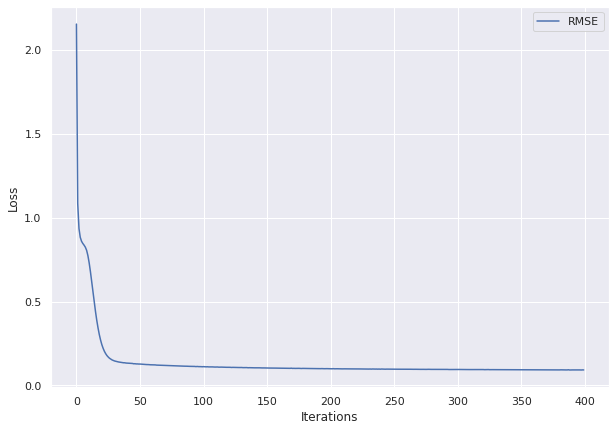

In [ ]:
iters = list(train_loss.keys())
values = list(train_loss.values())

plt.figure(figsize=(10, 7))
plt.plot(iters, values, label="RMSE")
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
test_loss = testing_model(dataset=test_set, model=model, loss_fn=rmse_loss_fn, cuda=cuda, 
              batch_size=batch_size)
print(f'Mean Test loss: {round(test_loss, 2)}')

Mean Test loss: 1.31


In [ ]:
n_clusters = 10

X = model.item_emb.weight.data.cpu().numpy()
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=200, max_iter=1000)
labels = kmeans.fit_predict(X)

In [ ]:
movie_names_dict = data.ratings.join(
    data.movies, on='item').set_index('item')['title'].to_dict()

for cluster in tqdm(range(n_clusters), desc='Clustering'):
    movies_cluster = []
    print(f"Cluster #{cluster + 1}")

    for itemIdx in np.where(labels == cluster)[0]:
        itemId = train_set.idx2itemid[itemIdx]
        rating_count = train_df.loc[train_df.item == itemId].count()[0]
        movies_cluster.append((movie_names_dict[itemId], rating_count))
        sorted_cluster = sorted(movies_cluster, key=lambda tup: tup[1], reverse=True)[:10]

    for m in sorted_cluster:
        print(f"\t{m[0]}")

Clustering:   0%|          | 0/10 [00:00<?, ?it/s]

Cluster #1
	Eternal Sunshine of the Spotless Mind (2004)
	Beautiful Mind, A (2001)
	Green Mile, The (1999)
	Bourne Identity, The (2002)
	Breakfast Club, The (1985)
	WALL·E (2008)
	V for Vendetta (2006)
	Ice Age (2002)
	Prestige, The (2006)
	Dark Knight Rises, The (2012)
Cluster #2
	Problem Child (1990)
	Flintstones in Viva Rock Vegas, The (2000)
	Spice World (1997)
	Stuart Saves His Family (1995)
	Species II (1998)
	Bubble Boy (2001)
	Catwoman (2004)
	Jason X (2002)
	Problem Child 2 (1991)
	Mortal Kombat: Annihilation (1997)
Cluster #3
	Shrek 2 (2004)
	Meet the Parents (2000)
	Slumdog Millionaire (2008)
	Scary Movie (2000)
	Shanghai Noon (2000)
	The Lego Movie (2014)
	Robots (2005)
	Cloudy with a Chance of Meatballs (2009)
	Scooby-Doo (2002)
	Rango (2011)
Cluster #4
	Shawshank Redemption, The (1994)
	Silence of the Lambs, The (1991)
	Toy Story (1995)
	Usual Suspects, The (1995)
	Godfather, The (1972)
	Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
	Fargo

# References
F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4: 19:1–19:19. https://doi.org/10.1145/2827872

https://github.com/SpencerPao/Data_Science/tree/main/Recommendation%20Systems

https://colab.research.google.com/drive/1-v9cw18wTDjaCUlECKHsQnHeisLKyG8U#scrollTo=ETrwA7hW-NhV

https://pytorch.org/docs/stable/index.html

https://github.com/yanneta/pytorch-tutorials/blob/master/collaborative-filtering-nn.ipynb

https://medium.com/programadores-ajudando-programadores/k-means-o-que-%C3%A9-como-funciona-aplica%C3%A7%C3%B5es-e-exemplo-em-python-6021df6e2572